In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [0]:
# uncomment below to use cuda

#use_cuda=True 

In [0]:
class DatasetMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [0]:
#dataset augmentation
transform=transforms.Compose([
                            transforms.ToPILImage(),
                           # Add random transformations to the image.
                           transforms.RandomAffine(
                               degrees=20,
                               translate=(0.1, 0.2),
                               shear=(-10, 20, -10, 20),
                               scale=(0.60, 1.25)),

                           transforms.ToTensor()
                       ])

In [0]:
dataset = DatasetMNIST('MNIST/train.csv', transform=transform)

In [0]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

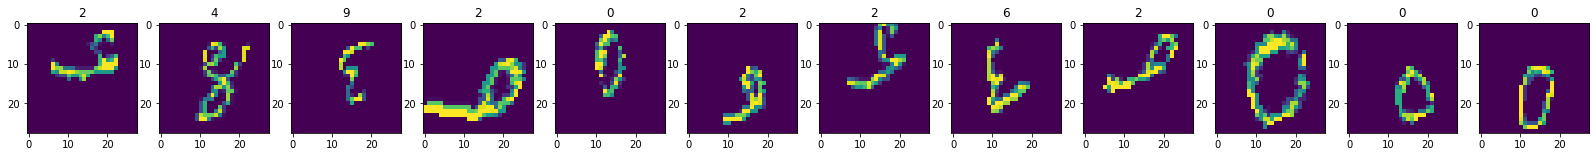

In [9]:
# display dataset
fig=plt.figure(figsize=(28, 28))
columns = 12
rows = 1
for i in range(1, columns*rows +1):
    r=random.randint(2,int(len(dataset)/columns*rows))
    img, lab = dataset.__getitem__(i*r)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.title(lab)
plt.show()

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [0]:
net = CNN()
#net.cuda()   # <- uncomment to use cuda
model = net

In [12]:
# train

optimizer = torch.optim.Adagrad(model.parameters(),lr=0.01)#, momentum=0.9)
error = nn.CrossEntropyLoss()

EPOCHS = 20
train_losses = []
model.train()

for epoch in range(EPOCHS):
    correct = 0
    running_loss=0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
#         var_X_batch = var_X_batch.cuda()  # <- uncomment to use cuda
#         var_y_batch = var_y_batch.cuda()
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == var_y_batch).sum()
        #print(correct)

        if batch_idx % 50 == 0:
            print('\t\tEpoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\t Accuracy:{:.2f}%'.format(
                epoch, 
                batch_idx*len(X_batch), 
                len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                loss.item(), 
                float(correct*100) / float(batch_size*(batch_idx+1))))
    train_losses.append(train_loss/len(train_loader))
        

Epoch : 0 [0/60000 (0%)]	Loss: 2.32155	 Accuracy:3.12%
Epoch : 0 [1600/60000 (3%)]	Loss: 1.82640	 Accuracy:19.73%
Epoch : 0 [3200/60000 (5%)]	Loss: 1.76597	 Accuracy:28.81%
Epoch : 0 [4800/60000 (8%)]	Loss: 1.26413	 Accuracy:37.11%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.11553	 Accuracy:43.25%
Epoch : 0 [8000/60000 (13%)]	Loss: 0.69073	 Accuracy:48.66%
Epoch : 0 [9600/60000 (16%)]	Loss: 0.47195	 Accuracy:52.77%
Epoch : 0 [11200/60000 (19%)]	Loss: 0.68628	 Accuracy:56.43%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.51836	 Accuracy:59.29%
Epoch : 0 [14400/60000 (24%)]	Loss: 0.60299	 Accuracy:61.90%
Epoch : 0 [16000/60000 (27%)]	Loss: 0.65446	 Accuracy:64.08%
Epoch : 0 [17600/60000 (29%)]	Loss: 0.13678	 Accuracy:65.98%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.51971	 Accuracy:67.44%
Epoch : 0 [20800/60000 (35%)]	Loss: 0.36332	 Accuracy:68.86%
Epoch : 0 [22400/60000 (37%)]	Loss: 0.33434	 Accuracy:69.94%
Epoch : 0 [24000/60000 (40%)]	Loss: 0.38905	 Accuracy:71.03%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.3